<a href="https://colab.research.google.com/github/hellojohnkim/mmai891/blob/main/24_891_JohnKim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMAI 891: Individual Assignment

Version 1: Updated February 4, 2024

- John Kim
- 20439250
- MMAI 2024 891
- Genius Makers by Cade Metz
- Due April 21, 2024

# Preliminaries: Inspect and Set up environment

In [ ]:
import datetime
import pandas as pd
import numpy as np

In [ ]:
print(datetime.datetime.now())

2024-04-15 17:56:34.459027


In [ ]:
!which python

/usr/local/bin/python


In [ ]:
!python --version

Python 3.10.12


In [ ]:
!echo $PYTHONPATH

/env/python


In [ ]:
# TODO: install any packages you need to here. For example:
#pip install unidecode

# Question 1: Sentiment Analysis via Shallow ML


**Marking**

The coding parts (i.e., 1.a, 1.b, 1.c4) will be marked based on:

- *Correctness*. Code clearly and fully performs the task specified.
- *Reproducibility*. Code is fully reproducible. I.e., you (and I) are able to run this Notebook again and again, from top to bottom, and get the same results each time.
- *Style*. Code is organized. All parts commented with clear reasoning and rationale. No old code laying around. Code easy to follow.


Parts 2 and 3 will be marked on:

- *Quality*. Response is well-justified and convincing. Responses uses facts and data where possible.
- *Style*. Response uses proper grammar, spelling, and punctuation. Response is clear and professional. Response is complete, but not overly-verbose. Response follows length guidelines.


In [ ]:
# DO NOT MODIFY THIS CELL

# First, we'll read the provided labeled training data
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1b8MAiN-xBdk6scM-DnufkuijDZivZJqM")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB


In [ ]:
# DO NOT MODIFY THIS CELL

# Next, we'll split it into training and test
from sklearn.model_selection import train_test_split

X = df['Sentence']
y = df['Polarity']

# So that we can evaluate how well our model is performing, we split our training data
# into training and validation.

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

## Part 1.a: Preprocessing and FE Pipeline

Clean and preprocess the data (i.e., `X_train`) as you see necessary. Extract features from the text (i.e., vectorization using BOW and/or Bag of N-Grams and/or topics and/or lexical features).


In [ ]:
#Step 1 - Import Libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:

#Step 2 - Define a function to clean text
def clean_text(text, use_stopwords=True, use_lemmatization=True):
    # Normalize text to Unicode form
    text = unicodedata.normalize('NFKC', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert to lower case
    tokens = [w.lower() for w in tokens]
    # Remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # Apply lemmatization
    lemmatizer = WordNetLemmatizer()
    if use_lemmatization:
        stripped = [lemmatizer.lemmatize(w) for w in stripped]
    # Remove non-alphabetic tokens
    words = [word for word in stripped if word.isalpha()]
    # Filter out stop words
    if use_stopwords:
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
    return ' '.join(words)


In [ ]:
#Step 3 - Clean X_train using text cleaning function, call it X_train_cleaned
X_train_cleaned = X_train.apply(clean_text)

In [ ]:
#Step 4 - Feature Extraction using Bag of Words and N-grams
# Initialize a CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2))

# Fit and transform the training data
X_train_features = vectorizer.fit_transform(X_train_cleaned)


In [ ]:
# To check the feature names
feature_names = vectorizer.get_feature_names_out()

# Now X_train_features is ready for training a model

In [ ]:
# Sum up the counts of each term.
sum_words = X_train_features.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

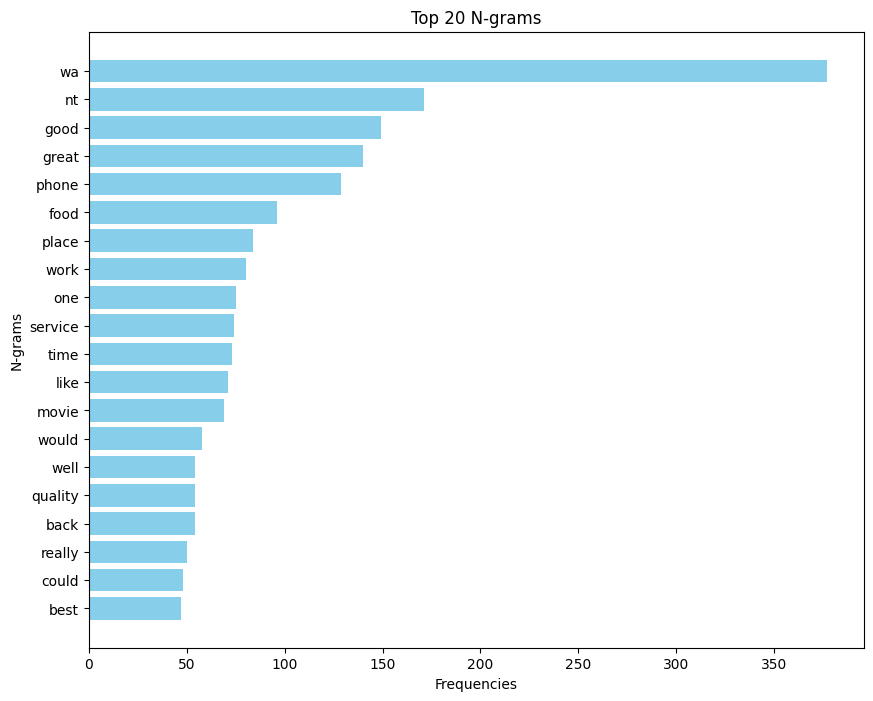

In [ ]:
import matplotlib.pyplot as plt

# Get the top 20 n-grams
top_ngrams = words_freq[:20]
words = [i[0] for i in top_ngrams]
frequencies = [i[1] for i in top_ngrams]

# Create the plot
plt.figure(figsize=(10, 8))
plt.barh(words, frequencies, color='skyblue')
plt.xlabel('Frequencies')
plt.ylabel('N-grams')
plt.title('Top 20 N-grams')
plt.gca().invert_yaxis()  # Invert axis to have the highest counts on top
plt.show()


## Part 1.b: Model Training/Tuning/Cross Validation

Use your favorite shallow ML algorithm (such as decision trees, KNN, random forest, boosting variants) to train a classification model.  Don’t forget everything we’ve learned in the machine learning course: hyperparameter tuning, cross-validation, handling imbalanced data, etc. Make reasonable decisions and try to create the best-performing model that you can.


In [ ]:
#Step 1 - Import Libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from pattern.text.en import suggest
import numpy as np


In [ ]:
# Step 2 - Handle Imbalanced Data with SMOTE
# Step 3 - Hyperparameter Tuning with Cross-Validation with GridSearchCV and SMOTE

# Define a pipeline that first oversamples then runs the classifier
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('knn', KNeighborsClassifier())
])

# Parameters of the KNN classifier to tune
parameters = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

# Using stratified K-folds to maintain the percentage of samples for each class
cv = StratifiedKFold(n_splits=5)

# Grid search object with KNN and use of cross-validation
grid_search = GridSearchCV(pipeline, parameters, cv=cv, scoring='accuracy', verbose=1)
grid_search.fit(X_train_features, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': [3, 5, 7, 9, 11],
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [ ]:
# Predict on the validation set
X_val_cleaned = X_val.apply(clean_text)
X_val_features = vectorizer.transform(X_val_cleaned)  # Make sure to transform the validation set
y_pred = grid_search.predict(X_val_features)

# Print the classification report and confusion matrix
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))


              precision    recall  f1-score   support

           0       0.66      0.91      0.77       323
           1       0.82      0.46      0.59       277

    accuracy                           0.70       600
   macro avg       0.74      0.69      0.68       600
weighted avg       0.73      0.70      0.69       600

[[294  29]
 [149 128]]


In [ ]:
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validated score:", grid_search.best_score_)


Best parameters found: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
Best cross-validated score: 0.6377777777777778


## Part 1.c: Model Assessment

Use your model to predict the sentiment of the testing data. Measure the performance (e.g., accuracy, AUC, F1-score) of your model.

In [ ]:
# DO NOT MODIFY THIS CELL

test_df = pd.read_csv("https://drive.google.com/uc?export=download&id=1taoTluPBUMt9JkKAnlqDTrU49DJFpJGW")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  600 non-null    object
 1   Polarity  600 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ KB


In [ ]:
# Assuming `clean_text` function has been defined as shown earlier
test_df['cleaned_text'] = test_df['Sentence'].apply(clean_text)

# Vectorize the test data using the same vectorizer fitted on the training data
X_test_features = vectorizer.transform(test_df['cleaned_text'])


In [ ]:
y_test_pred = grid_search.predict(X_test_features)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# Accuracy
accuracy = accuracy_score(test_df['Polarity'], y_test_pred)
print(f"Accuracy: {accuracy}")

# F1-Score
f1 = f1_score(test_df['Polarity'], y_test_pred, average='weighted')  # 'weighted' in case of class imbalance
print(f"F1-Score: {f1}")

# AUC can only be computed for binary classification or by one-vs-rest for multiclass classification
if len(np.unique(y_train)) == 2:
    # Predicting probabilities for AUC
    y_test_prob = grid_search.predict_proba(X_test_features)[:, 1]
    auc = roc_auc_score(test_df['Polarity'], y_test_prob)
    print(f"AUC: {auc}")
else:
    print("AUC is not calculated because it's not a binary classification.")

# Detailed classification report
report = classification_report(test_df['Polarity'], y_test_pred)
print(report)


Accuracy: 0.5783333333333334
F1-Score: 0.5181348189449905
AUC: 0.7011165410604356
              precision    recall  f1-score   support

           0       0.53      0.95      0.68       287
           1       0.85      0.23      0.37       313

    accuracy                           0.58       600
   macro avg       0.69      0.59      0.53       600
weighted avg       0.70      0.58      0.52       600



## Part 2: Given the performance of your model, are you satisfied with the results? Explain.

Keep your response to 1000 characters or less.

TODO: Insert answer here.

## Part 3: Show five test instances in which your model was incorrect. Dive deep and find out why your model was wrong.

Keep your response to 1000 characters or less.

In [ ]:
##Step 1: Identify Misclassified Instances

# Add predictions to the test dataframe
test_df['predicted_polarity'] = y_test_pred

# Find instances where the predicted polarity does not match the actual polarity
misclassified = test_df[test_df['Polarity'] != test_df['predicted_polarity']]


In [ ]:
#Step 2: Display Five Misclassified Instances
# Randomly sample 5 misclassified instances for analysis
misclassified_samples = misclassified.sample(n=5, random_state=42)
print(misclassified_samples)

                                              Sentence  Polarity  \
536  The two main characters may be two of the most...         1   
10   A world better than 95% of the garbage in the ...         1   
242  There's barely a boring moment in the film and...         1   
532  The interplay between Martin and Emilio contai...         1   
329  The movie is full of wonderful dancing (hence ...         1   

                                          cleaned_text  predicted_polarity  
536  two main character may two believable child ev...                   0  
10                  world better garbage theatre today                   0  
242     barely boring moment film plenty humorous part                   0  
532  interplay martin emilio contains wonderful che...                   0  
329           movie full wonderful dancing hence title                   0  


# Question 2: Conceptual Understanding of the SOTA


**Marking**

The following questions will be marked on:

- *Quality*. Response is well-justified and convincing. Responses uses facts and data where possible.
- *Style*. Response uses proper grammar, spelling, and punctuation. Response is clear and professional. Response is complete, but not overly-verbose. Response follows length guidelines.


## Part 1: What is transfer learning and fine-tuning in NLP? What advantages does it have over training from scratch?


In the domain of NLP, transfer learning is a strategic approach where we utilize a model pre-trained on extensive datasets and tailor it to our specific needs. Fine-tuning further refines this process by adjusting the model to the intricacies of our targeted task. This methodology stands out for its efficiency, requiring significantly less time and data to achieve high-quality outcomes compared to traditional models built from the ground up. It leverages the foundational language understanding already embedded in the pre-trained model, providing a robust starting point and facilitating enhanced performance, even in data-scarce scenarios. This approach not only streamlines the development process but also amplifies the potential for innovative solutions in the field of NLP.

characters: 789

## Part 2: What is a Large Language Model (LLM) and what are their strengths and weaknesses?


A Large Language Model (LLM) like GPT excels in generating human-like text, understanding context, and performing diverse tasks in natural language. Strengths include their versatility across various applications, deep language understanding, and adaptability to specific domains via fine-tuning. However, LLMs face challenges like data bias, which can perpetuate ethical issues, and interpretability problems, complicating error analysis. They also demand significant computational resources, impacting accessibility and the environment. Despite their proficiency, LLMs can sometimes produce inaccurate or nonsensical outputs, especially in complex situations.

# Question 3 (Optional/Bonus): Sentiment Analysis via Deep ML

This question is optional and is worth up to 5 extra credit marks.

Use deep learning (e.g., RNNs and variants, CNNs and variants, and/or transformers) to build a model on the same dataset as Q1 and compare the results with the Shallow ML model.

You may train your own deep ML model (using, e.g., the keras library) or fine-tune a pretrained deep ML model (using, e.g., the transformers library and the Huggingface ecoystem).

In [ ]:
# DO NOT MODIFY THIS CELL

# First, we'll read the provided labeled training data
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1b8MAiN-xBdk6scM-DnufkuijDZivZJqM")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2400 non-null   object
 1   Polarity  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB


In [ ]:
# DO NOT MODIFY THIS CELL

# Next, we'll split it into training and test
from sklearn.model_selection import train_test_split

X = df['Sentence']
y = df['Polarity']

# So that we can evaluate how well our model is performing, we split our training data
# into training and validation.

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [ ]:
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments

# Load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Function to tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['Sentence'], padding="max_length", truncation=True)

# Convert the Pandas dataframes to Hugging Face dataset format
train_dataset = Dataset.from_pandas(df.iloc[X_train.index])
val_dataset = Dataset.from_pandas(df.iloc[X_val.index])

# Apply the tokenize function and remove original columns
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=['Sentence', 'Polarity'])
val_dataset = val_dataset.map(tokenize_function, batched=True, remove_columns=['Sentence', 'Polarity'])

# Add a column for labels which is required by Hugging Face Trainer
train_dataset = train_dataset.add_column("labels", y_train.tolist())
val_dataset = val_dataset.add_column("labels", y_val.tolist())


Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Start training
trainer.train()


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
10,0.693200
20,0.679200
30,0.693200
40,0.684300
50,0.685900
60,0.671600
70,0.655500
80,0.646100
90,0.570500
100,0.474600


TrainOutput(global_step=339, training_loss=0.32095893294410366, metrics={'train_runtime': 239.6967, 'train_samples_per_second': 22.528, 'train_steps_per_second': 1.414, 'total_flos': 715323952742400.0, 'train_loss': 0.32095893294410366, 'epoch': 3.0})

In [ ]:
#Step 6: Evaluation
#Evaluate the model on the validation set to see how well it performs.


results = trainer.evaluate()
print(results)


{'eval_loss': 0.2601062059402466, 'eval_runtime': 10.6433, 'eval_samples_per_second': 56.374, 'eval_steps_per_second': 0.94, 'epoch': 3.0}


In [ ]:
#Step 7: Save the Model
#After training, you may want to save the model and the tokenizer for later use.

model_path = "./sentiment-distilbert-model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)



('./sentiment-distilbert-model/tokenizer_config.json',
 './sentiment-distilbert-model/special_tokens_map.json',
 './sentiment-distilbert-model/vocab.txt',
 './sentiment-distilbert-model/added_tokens.json',
 './sentiment-distilbert-model/tokenizer.json')

In [ ]:
# Get predictions
predictions = trainer.predict(val_dataset)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix

# Extract logits
logits = predictions.predictions

# Convert logits to probabilities using softmax
probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)

# Extract predicted labels
predicted_labels = np.argmax(logits, axis=1)

# Extract True labels
true_labels = np.array(val_dataset["labels"])


In [ ]:
# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

# AUC - This metric is only meaningful for binary classification tasks
if len(np.unique(true_labels)) == 2:
    auc = roc_auc_score(true_labels, probabilities[:, 1])  # Probabilities for the positive class
    print(f"AUC: {auc}")
else:
    print("AUC is not applicable for non-binary classification tasks.")

# F1-Score
f1 = f1_score(true_labels, predicted_labels, average='weighted')  # Use 'weighted' to handle imbalanced classes
print(f"F1-Score: {f1}")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)


Accuracy: 0.9216666666666666
AUC: 0.9785628862983536
F1-Score: 0.9217507258495342
Confusion Matrix:
[[294  29]
 [ 18 259]]


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       323
           1       0.90      0.94      0.92       277

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600

